In [2]:
import os
import cv2
import torch 
import torchvision 
import numpy as np 
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

c:\Users\parigoel\Anaconda3\envs\greentrackenv\Lib\site-packages\onnxruntime\capi\onnxruntime_validation.py:26: UserWarning: Unsupported Windows version (11). ONNX Runtime supports Windows 10 and above, only.
  warnings.warn(


PyTorch version: 2.4.1
Torchvision version: 0.19.1
CUDA is available: False


In [3]:
# SAM initial model loading
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
sam_checkpoint = "../models/sam_vit_h_4b8939.pth"
model_type = "vit_h"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

c:\Users\parigoel\Anaconda3\envs\greentrackenv\Lib\site-packages\segment_anything\build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [4]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.9]])
        img[m] = color_mask
    ax.imshow(img)

IMG shape:  (1024, 1024, 3)


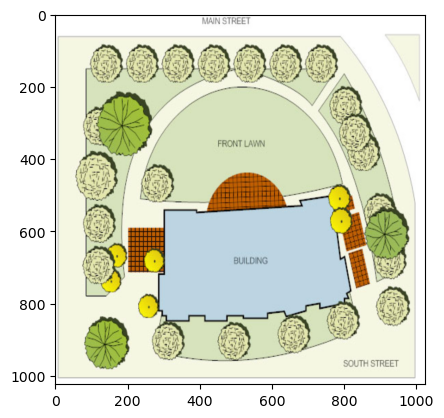

In [5]:
img_path = "../data/landscape_plans/landscape3.jpg"
img = cv2.imread(img_path)

# resizing the image to 1024x1024
img = cv2.resize(img, (1024, 1024))
print("IMG shape: ", img.shape)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [6]:
# Automatic Mask Generator

# mask_generator = SamAutomaticMaskGenerator(
#     model=sam,
#     points_per_side=51,
#     pred_iou_thresh=0.86,
#     stability_score_thresh=0.92,
#     crop_n_layers=1,
#     crop_n_points_downscale_factor=2,
#     min_mask_region_area=100,  # Requires open-cv to run post-processing
# )

mask_generator = SamAutomaticMaskGenerator(model=sam)

Number of masks:  61
Shape of individual mask:  (1024, 1024)


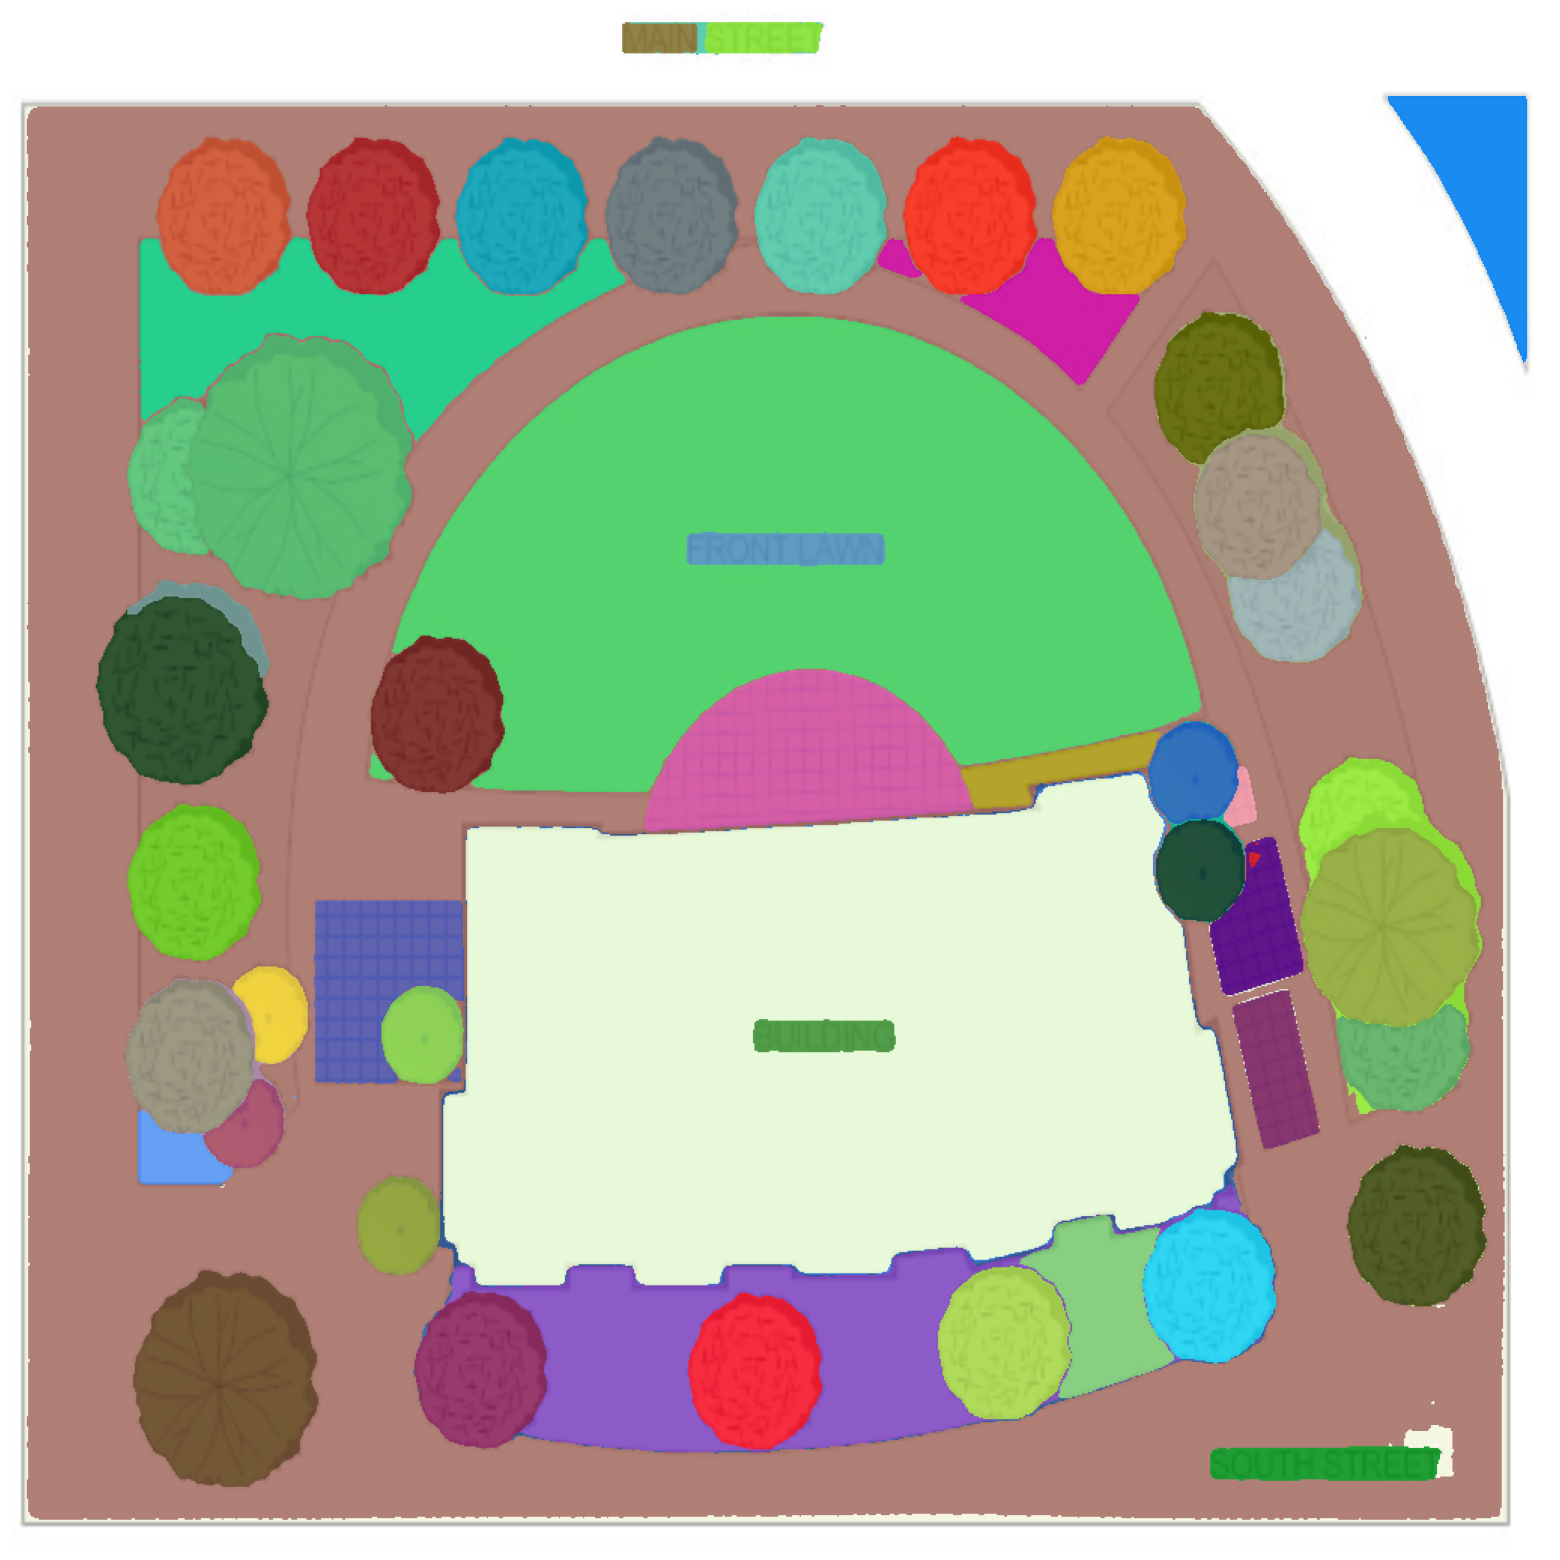

In [7]:
# Generate mask using automatic-mask-generator
masks = mask_generator.generate(img_rgb)
masks = sorted(masks, key=(lambda x: x['area']), reverse=True)
print("Number of masks: ", len(masks))
print("Shape of individual mask: ",masks[0]['segmentation'].shape)

plt.figure(figsize=(20,20))
plt.imshow(img_rgb)
show_anns(masks)
plt.axis('off')
plt.show() 

In [24]:
def convert_yolo_bbox_info(img_w, img_h,x,y,w,h):
    box = np.zeros(4)
    dw = 1./img_w
    dh = 1./img_h
    x = x/dw
    w = w/dw
    y = y/dh
    h = h/dh
    
    # top left corner of rect
    box[0] = x-(w/2.0)
    box[1] = y-(h/2.0)
    
    # bottom right corner of rect
    box[2] = x+(w/2.0)
    box[3] = y+(h/2.0)

    return box.round().astype(int)

def load_yolo_one_file(labels_file_path, img_size):
    bboxes = []
    txt_file = open(labels_file_path, "r")
    
    # Read labels from text file
    lines = txt_file.read().splitlines()
    for line in lines:
        value = line.split()
        x, y, w, h = list(map(float, value[1:]))
        bb = convert_yolo_bbox_info(img_size[1], img_size[0], x, y, w, h)
        bboxes.append(bb)
    
    return bboxes
    
def load_yolo_dataset():
    labels_path = '../data/dataset/train/labels/'
    imgs_path = '../data/dataset/train/images/'
    # Get yolo txt file list
    labels_file_list = []
    for file in os.listdir(labels_path):
        if file.endswith(".txt"):
            labels_file_list.append(file)
        
    dataset=[]
    
    for label_file_name in labels_file_list:
        img_file_name = label_file_name.rstrip(".txt") + ".jpg"
        img_file_path = imgs_path + img_file_name
        img = cv2.imread(img_file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        txt_file = open(labels_path+label_file_name, "r")
    
        # Read labels from text file
        lines = txt_file.read().splitlines()
        for line in lines:
            value = line.split()
            x, y, w, h = list(map(float, value[1:]))
            bbox = convert_yolo_bbox_info(img.shape[1], img.shape[0], x, y, w, h)
            tree_icon = img[bbox[1]:bbox[3], bbox[0]:bbox[2],:]
            tree_icon = cv2.resize(tree_icon,(48,48))
            #tree_icon = cv2.cvtColor(tree_icon, cv2.COLOR_RGB2GRAY)
            dataset.append(tree_icon)
    
    return dataset

In [65]:
import torch 
import torch.nn as nn 
import torch.optim as optim

# Build the CNN classifier model
class TreeClassifier(nn.Module):
    def __init__(self):
        super(TreeClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(32 * 12 * 12, 64)
        self.relu3 = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.reshape(x.shape[0],-1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x


In [67]:
icons = np.array(load_yolo_dataset())
icons = icons.astype('float32') / 255.0  # Normalize
icons = torch.from_numpy(icons)
icons = torch.permute(icons, (0,3,1,2)) # move color channel to second dim..this order is expected by the model
labels = np.ones(len(icons))  # Icons are of the same class
labels = torch.from_numpy(labels)
labels = labels.float().unsqueeze(1)

model = TreeClassifier()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

torch.Size([99, 1])


In [70]:
batch_size = 32
for epoch in range(10):
    running_loss = 0.0
    total_icons = len(icons)
    running_idx_icons = 0 
    counter = 0
    if running_idx_icons <= total_icons:
        start_pos = running_idx_icons
        end_pos = running_idx_icons + 32 if running_idx_icons + 32 <= total_icons else total_icons
        inputs = icons[start_pos:end_pos]
        gt = labels[start_pos:end_pos]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, gt)
        loss.backward()
        optimizer.step()
        counter += 1
        running_idx_icons += batch_size 
    print('[%d] loss: %.3f' % (epoch + 1, running_loss / counter))
print('Finished training')
        
    

[1] loss: 0.000
[2] loss: 0.000
[3] loss: 0.000
[4] loss: 0.000
[5] loss: 0.000
[6] loss: 0.000
[7] loss: 0.000
[8] loss: 0.000
[9] loss: 0.000
[10] loss: 0.000
Finished training


In [ ]:
def classify_image(input_image_path):
    img = load_img(input_image_path, target_size=(64, 64))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize
    prediction = model.predict(img_array)
    return prediction[0][0]  # Returns a probability

result = classify_image('path_to_input_image')

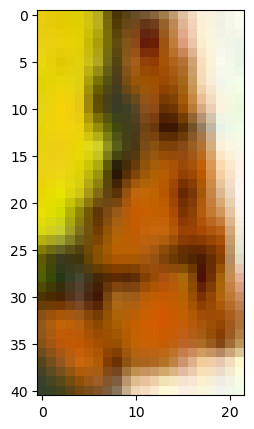

tensor([[1.]], grad_fn=<SigmoidBackward0>)


In [142]:
mask = (masks[60]['segmentation']).astype(np.uint8)
# Get the bounding box of the segmented object 
(x,y,w,h) = cv2.boundingRect(mask)
segmented_object = img_rgb[y:y+h, x:x+w]
plt.figure(figsize=(5,5))
plt.imshow(segmented_object)
plt.show()

segmented_object = cv2.resize(segmented_object,(48,48))
segmented_object = segmented_object.astype('float32') / 255.0  # Normalize
segmented_object = torch.from_numpy(segmented_object)
segmented_object = torch.permute(segmented_object, (2,0,1)).unsqueeze(0) # move color channel to second dim..this order is expected by the model
prediction = model(segmented_object)
print(prediction)
# mask = cv2.cvtColor(mask,cv2.COLOR_GRAY2BGR)
# print(mask.shape)
# print(img_rgb.shape)
#img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
#img_gray[~mask] = [0,0]
#masked_img = cv2.bitwise_and(img_gray, mask)
#print(masked_img.shape)